In [1]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm # progress bar, makes you look pro

# add parent dir to path
sys.path.append(os.path.abspath('..'))

from src.ingestion.ims_loader import load_raw_file, parse_filename_timestamp
from src.features.signal_math import calculate_time_domain_features

In [2]:
raw_data_dir = '../data/raw'
processed_data_dir = '../data/processed'

# get all files, sorted by time (filenames are timestamps)
files = sorted([f for f in os.listdir(raw_data_dir) if f != '.DS_Store'])
print(f"found {len(files)} data files.")

found 984 data files.


In [3]:
# this loop opens every file, calculates features, and stores them
feature_matrix = []

print("starting feature extraction pipeline...")

for filename in tqdm(files):
    # 1. parse timestamp from filename
    timestamp = parse_filename_timestamp(filename)
    
    # 2. load raw signal
    file_path = os.path.join(raw_data_dir, filename)
    signal = load_raw_file(file_path)
    
    # 3. calculate features (rms, kurtosis, etc.)
    # we use the function we wrote in src/features/signal_math.py
    features = calculate_time_domain_features(signal)
    
    # 4. add timestamp to the feature dictionary
    features['timestamp'] = timestamp
    
    feature_matrix.append(features)

print("extraction complete.")

starting feature extraction pipeline...


100%|██████████| 984/984 [00:02<00:00, 332.05it/s]

extraction complete.


In [4]:
# convert list of dicts to a pandas dataframe
df = pd.DataFrame(feature_matrix)

# set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)

# inspect the first few rows
print(df.head())

# save to csv
output_path = os.path.join(processed_data_dir, 'merged_bearing_data.csv')
df.to_csv(output_path)
print(f"feature matrix saved to {output_path}")

                          rms  kurtosis  skewness  peak_to_peak  crest_factor
timestamp                                                                    
2004-02-12 10:32:39  0.074179  3.628763  0.083993         0.840      6.120331
2004-02-12 10:42:39  0.075382  3.648291  0.052142         0.757      5.147086
2004-02-12 10:52:39  0.076230  3.513475  0.032808         0.903      6.598472
2004-02-12 11:02:39  0.078724  4.157953  0.041486         1.184      7.723217
2004-02-12 11:12:39  0.078474  3.603177  0.028224         0.782      4.982524
feature matrix saved to ../data/processed/merged_bearing_data.csv


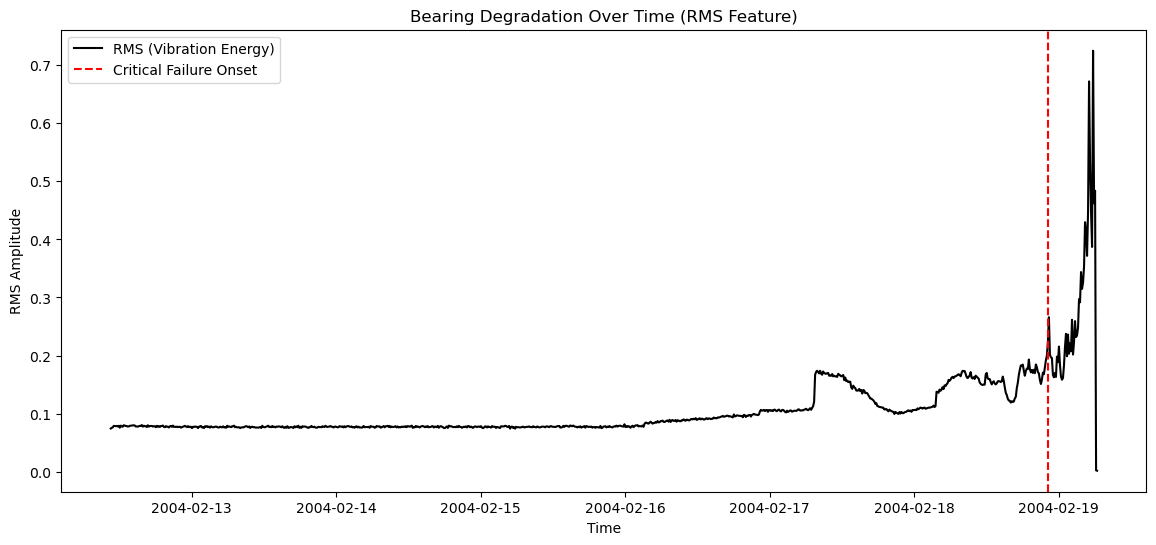

In [5]:
import matplotlib.pyplot as plt

# plot rms over time. this is the classic "run-to-failure" curve.
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['rms'], label='RMS (Vibration Energy)', color='black')
plt.axvline(df.index[-50], color='red', linestyle='--', label='Critical Failure Onset')
plt.title('Bearing Degradation Over Time (RMS Feature)')
plt.ylabel('RMS Amplitude')
plt.xlabel('Time')
plt.legend()
plt.show()